# **Driver Drowsiness Detection with Convolutional Neural Networks**

## Project Overview
This project involves building and evaluating a Convolutional Neural Network (CNN) for detecting driver drowsiness using a dataset of driver images. We use a pre-trained ResNet50 model, fine-tune it for our specific task, and evaluate its performance on a test set. The primary objectives are to:

- Load and preprocess the dataset.
- Define and modify a pre-trained ResNet50 model for binary classification.
- Train the model with data augmentation and early stopping techniques.
- Evaluate the model's performance using a confusion matrix.

## Table of Contents

Welcome to the Driver Drowsiness Detection project! This notebook will guide you through the process of building and evaluating a Convolutional Neural Network (CNN) for detecting driver drowsiness. Use the links below to navigate to different sections of the notebook.

1. [Installation and Import Libraries](#installation-and-import-libraries)
2. [Data Exploration](#data-exploration)
3. [Dataset Preparation](#dataset-preparation)
4. [Model Architecture](#model-architecture)
5. [Training the Model](#training-the-model)
6. [Evaluating the Model](#evaluating-the-model)
7. [The End](#the-end)

## 1. Installation and Import Libraries

Instructions for setting up the environment and installing dependencies.

In [1]:
#  !pip install torchsummary

In [2]:
import os
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import transforms
from torchvision import  transforms, models
from torchsummary import summary
from PIL import Image 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 2. Data Exploration
explore the dataset to understand its structure and contents. We visualize some sample images and check the distribution of classes in the dataset.


In [3]:
main_path = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'

drowsy_paths = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy_paths = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]

all_dirs = drowsy_paths +  non_drowsy_paths

random.shuffle(all_dirs)

total_size = len(all_dirs)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  

# Split the data
train_paths = all_dirs[:train_size]
val_paths = all_dirs[train_size:train_size + val_size]
test_paths = all_dirs[train_size + val_size:]

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

len_all_dirs = len(all_dirs)
len_train_paths = len(train_paths)
len_val_paths = len(val_paths)
len_test_paths = len(test_paths)

print(f"Total images: {len_all_dirs}")
print(f"Training set: {len_train_paths} images")
print(f"Validation set: {len_val_paths} images")
print(f"Test set: {len_test_paths} images")

Total images: 41793
Training set: 29255 images
Validation set: 8358 images
Test set: 4180 images


In [4]:
def extract_class_name(p):
    return p.split('/')[-2]

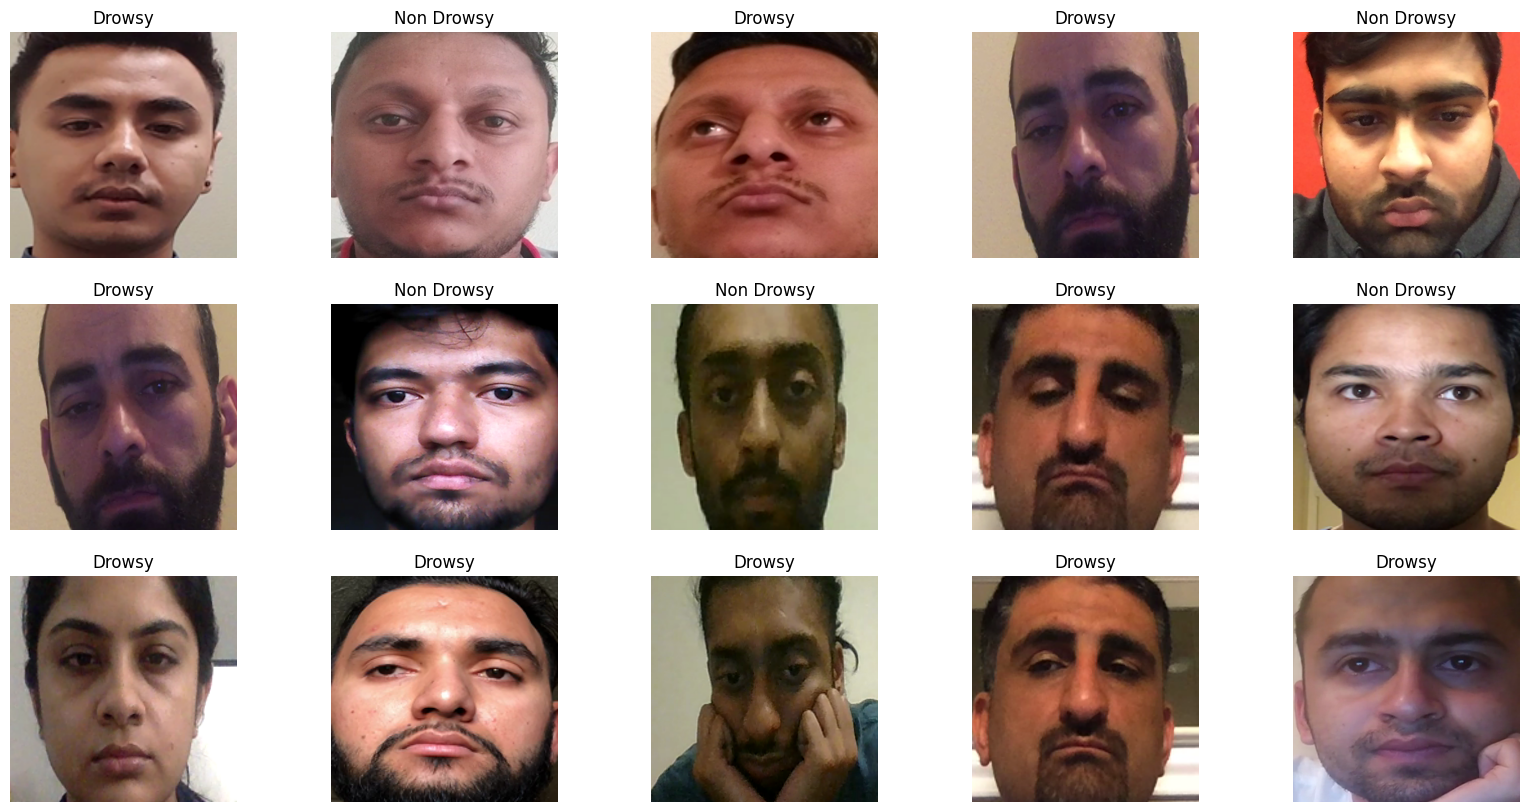

In [5]:
def show_images_with_labels(paths, num_images=15):
    plt.figure(figsize=(20, 10))
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images_with_labels(train_paths, num_images=15)

In [6]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  
device

device(type='cuda', index=0)

## 3. Dataset Preparation
load the dataset, apply transformations, and prepare DataLoaders for training, validation, and testing.

In [7]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = extract_class_name(img_path)

        if self.transform:
            image = self.transform(image)
        
        label = 0 if label == 'Drowsy' else 1

        return image, label

In [8]:
# Define data augmentation and transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),  
#     transforms.RandomRotation(10), 
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# Define transformations for validation (no augmentation)
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

In [9]:
train_dataset = MyDataset(train_paths, transform=train_transform)
val_dataset = MyDataset(val_paths, transform=test_val_transform)
test_dataset = MyDataset(test_paths, transform=test_val_transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 4. Model Architecture
We use a pre-trained ResNet50 model and modify the final layer to output two classes: Drowsy and Non Drowsy.

In [10]:
model = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last `n` layers

n = 3
child_counter = 0
for child in model.children():
    child_counter += 1
    if child_counter > len(list(model.children())) - n:
        for param in child.parameters():
            param.requires_grad = True



num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

model = model.to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
# [ *model.children()][-3:] 

## 5. Training the Model
implement the training loop and apply early stopping to prevent overfitting.

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0 or (i+1) == len(train_loader):
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss / (i+1)))
    
    avg_loss = running_loss / total_step
    return avg_loss


In [13]:
def evaluate_model(model, data_loader, criterion, device, dataset_type='Validation'):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = len(data_loader.dataset)
        total_loss = 0 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels) 
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
        print(f'{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}')
        return avg_loss, accuracy 

In [14]:
def checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter, path='best_model.pth'):
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), path)
        print(f"New best model saved with validation loss: {avg_val_loss:.4f}")

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            return True, best_val_loss, counter

    return False, best_val_loss, counter


In [15]:
def load_best_model(model, path='best_model.pth'):
    model.load_state_dict(torch.load(path))
    print("Best model loaded from", path)

In [16]:
num_epochs = 10
patience = 3
best_val_loss = float('inf')
counter = 0
learning_rate= 0.0001
train_losses = []
val_losses = []

In [17]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Train the model
total_step = len(train_loader)

In [18]:
for epoch in range(num_epochs):
    avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step)
    train_losses.append(avg_train_loss)
    
    avg_val_loss, _ = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(avg_val_loss)
    
    early_stop, best_val_loss, counter = checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter)
    if early_stop:
        break
        
    print('##'*20)

Epoch [1/10], Step [100/458], Train Loss: 0.2194
Epoch [1/10], Step [200/458], Train Loss: 0.1134
Epoch [1/10], Step [300/458], Train Loss: 0.0777
Epoch [1/10], Step [400/458], Train Loss: 0.0587
Epoch [1/10], Step [458/458], Train Loss: 0.0525
Validation Accuracy: 99.98% | Validation Loss: 0.0008
New best model saved with validation loss: 0.0008
########################################
Epoch [2/10], Step [100/458], Train Loss: 0.0046
Epoch [2/10], Step [200/458], Train Loss: 0.0025
Epoch [2/10], Step [300/458], Train Loss: 0.0019
Epoch [2/10], Step [400/458], Train Loss: 0.0017
Epoch [2/10], Step [458/458], Train Loss: 0.0016
Validation Accuracy: 100.00% | Validation Loss: 0.0002
New best model saved with validation loss: 0.0002
########################################
Epoch [3/10], Step [100/458], Train Loss: 0.0001
Epoch [3/10], Step [200/458], Train Loss: 0.0002
Epoch [3/10], Step [300/458], Train Loss: 0.0007
Epoch [3/10], Step [400/458], Train Loss: 0.0006
Epoch [3/10], Step [458

In [24]:
# Load the best model checkpoint after training
load_best_model(model)

Best model loaded from best_model.pth


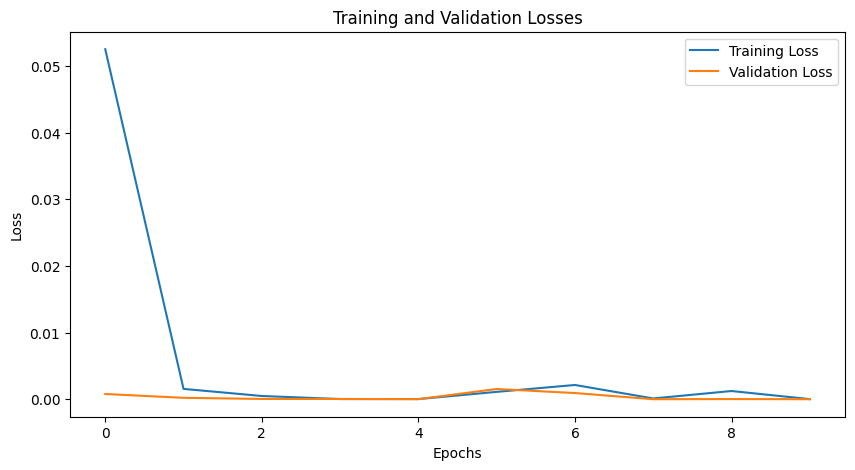

In [20]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

## 6. Evaluating the Model
evaluate the model's performance and visualize the confusion matrix.

In [21]:
## Model Evaluate On Test 
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device, dataset_type='Test')

Validation Accuracy: 100.00% | Validation Loss: 0.0000
Test Accuracy: 99.98% | Test Loss: 0.0009


In [22]:
def evaluate_and_confusion_matrix(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

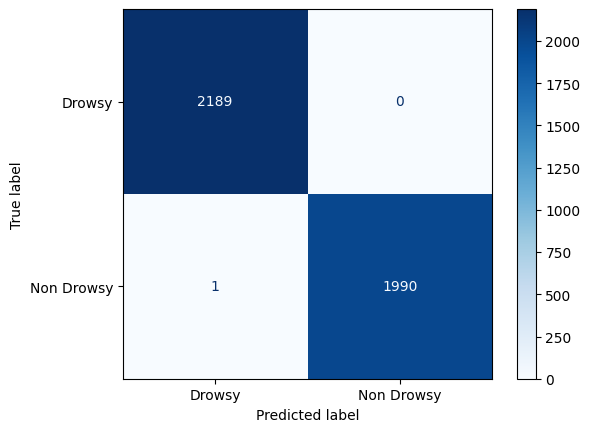

In [23]:
evaluate_and_confusion_matrix(model, test_loader, criterion, device)

## 7. The End
Hopefully, this notebook will be useful for everyone. Upvote if you like the work. Also, comment your feedback below, which would help me improve.